# Letters

## Description

Generate an image with the edges of the letters present in this noisy image


## Group ID

Identify your group here, including the number and name of each group's member

In [2]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

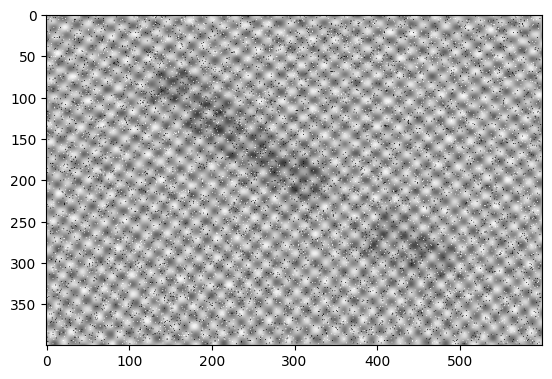

In [3]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
#print('Image Shape =', img.shape())
plt.imshow(img, cmap = 'gray')

# convert the image representation to SPFP
img_float32 = np.float32(img)

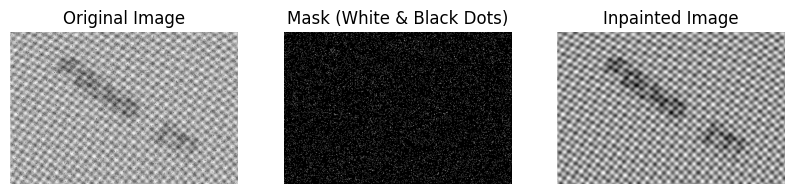

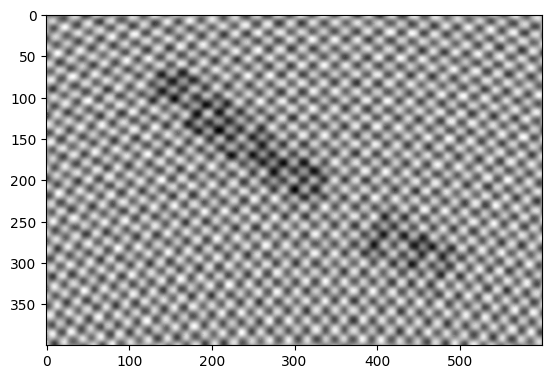

In [4]:
mask = (img == 0) | (img == 255)
mask = mask.astype(np.uint8) * 255  # Convert boolean mask to uint8 format

# Inpaint the noisy pixels
inpainted = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
inpainted_float32 = np.float32(inpainted)

# Display results using Matplotlib
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask (White & Black Dots)")
ax[1].axis("off")

ax[2].imshow(inpainted, cmap='gray')
ax[2].set_title("Inpainted Image")
ax[2].axis("off")

plt.show()

# show only the impainted image
plt.imshow(inpainted, cmap = 'gray')
plt.show()


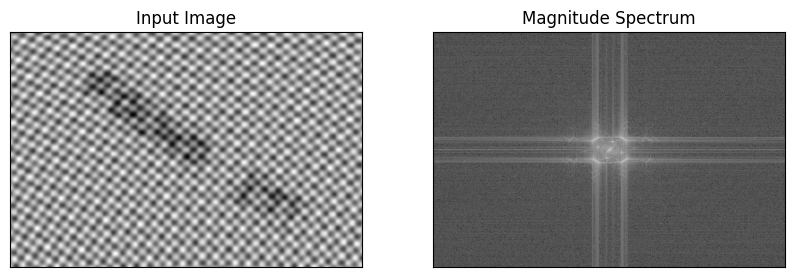

In [5]:
# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(inpainted_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

# display the image and the spectrum
fig = plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(inpainted, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show() 

# Usage of Notch Filters

We tried to use regular notch filters to remove the "checkboard" like noise.

In [6]:
# Compute the DFT
dft = cv2.dft(inpainted_float32, flags=cv2.DFT_COMPLEX_OUTPUT)

# Recenter the DFT
dft_shift = np.fft.fftshift(dft)

filtered_dft = dft_shift

# Get image dimensions
rows, cols = inpainted_float32.shape
crow, ccol = rows // 2 , cols // 2  # Center coordinates

# Define Notch Filter Centers
notch_centers = [(ccol - 30, crow - 20, 10), (ccol + 30, crow + 20, 10), (ccol - 30, crow + 20, 10), (ccol + 30, crow - 20, 10),
                 (ccol + 20, crow, 5), (ccol - 20, crow, 5), (ccol - 5, crow + 10, 5), (ccol + 5, crow - 10, 5)
                ]

# Donut Filter Centers
donut_centers = []

### Regular Notch Filter

In [7]:
def create_notch_filter(shape, notch_centers):
    mask = np.ones((shape[0], shape[1], 2), np.uint8)
    for center in notch_centers:
        x, y, r = center
        cv2.circle(mask, (x, y), r, (0, 0), thickness=-1)
    return mask

# Create Notch Filter Mask
notch_mask = create_notch_filter((rows, cols), notch_centers)

### Donut Filters

In order to try different approaches we decided to use a donut like mask instead of the regular circle

In [8]:
def create_donut_filter(shape, donut_centers):
    """Creates a donut (ring-shaped) notch filter."""
    mask = np.ones((shape[0], shape[1], 2), np.float32)
    
    for center in donut_centers:
        x, y, outer_r, inner_r = center
        cv2.circle(mask, (x, y), outer_r, (0, 0), thickness=-1)
        cv2.circle(mask, (x, y), inner_r, (1, 1), thickness=-1) 

    return cv2.GaussianBlur(mask, (5, 5), 0) 

# Create Donut Filter Mask
donut_mask = create_donut_filter((rows, cols), donut_centers)

### Result

Now depending on what we applied before we can get the final result.
Overall the donut approach didn't prove to be that useful but it was a fun idea.

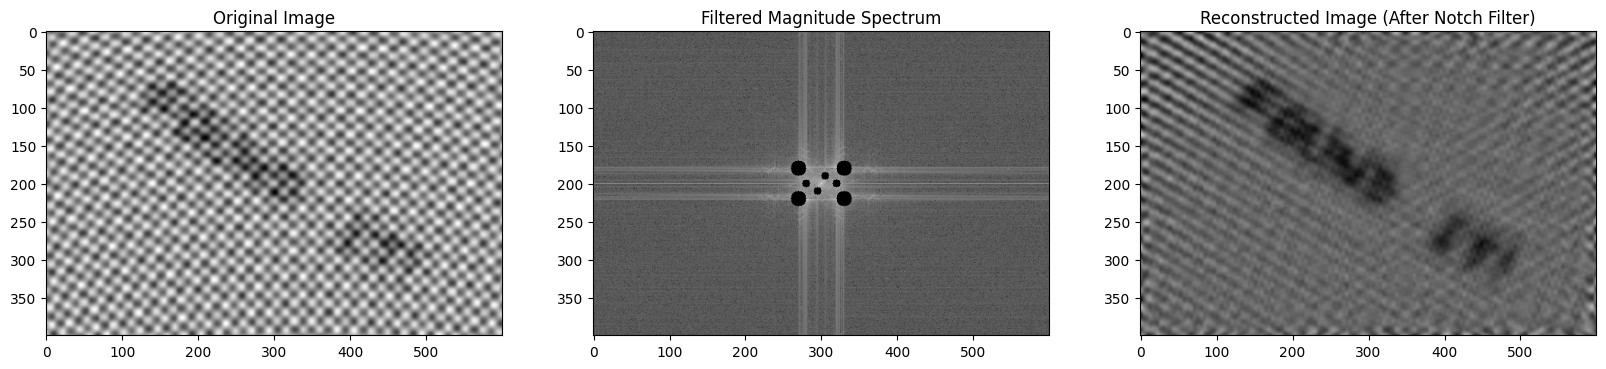

In [9]:
# Apply Notch Filter and Donut Filter
filtered_dft *=  notch_mask
filtered_dft *= donut_mask

# Compute the magnitude spectrum (for visualization)
magnitude_spectrum = cv2.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1])
magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)

# Inverse DFT
idft_shift = np.fft.ifftshift(filtered_dft)
reconstructed = cv2.idft(idft_shift)
reconstructed = cv2.magnitude(reconstructed[:, :, 0], reconstructed[:, :, 1])

# Normalize for display
reconstructed = cv2.normalize(reconstructed, None, 0, 255, cv2.NORM_MINMAX)
reconstructed = np.uint8(reconstructed)

# Display Results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(inpainted, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Filtered Magnitude Spectrum')

axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title('Reconstructed Image (After Notch Filter)')

plt.show()

### Inverted Notch Filters

Let's try the other way around

In [10]:
def create_inverted_notch_filter(shape, notch_centers):
    mask = np.zeros((shape[0], shape[1], 2), np.uint8)  # Start with zeros
    for center in notch_centers:
        x, y, r = center
        cv2.circle(mask, (x, y), r, (1, 1), thickness=-1)  # Set circles to 1
    return mask

notch_centers = [(ccol, crow, 40)]

# Create Inverted Notch Filter Mask
inverted_notch_mask = create_inverted_notch_filter((rows, cols), notch_centers)

### Result

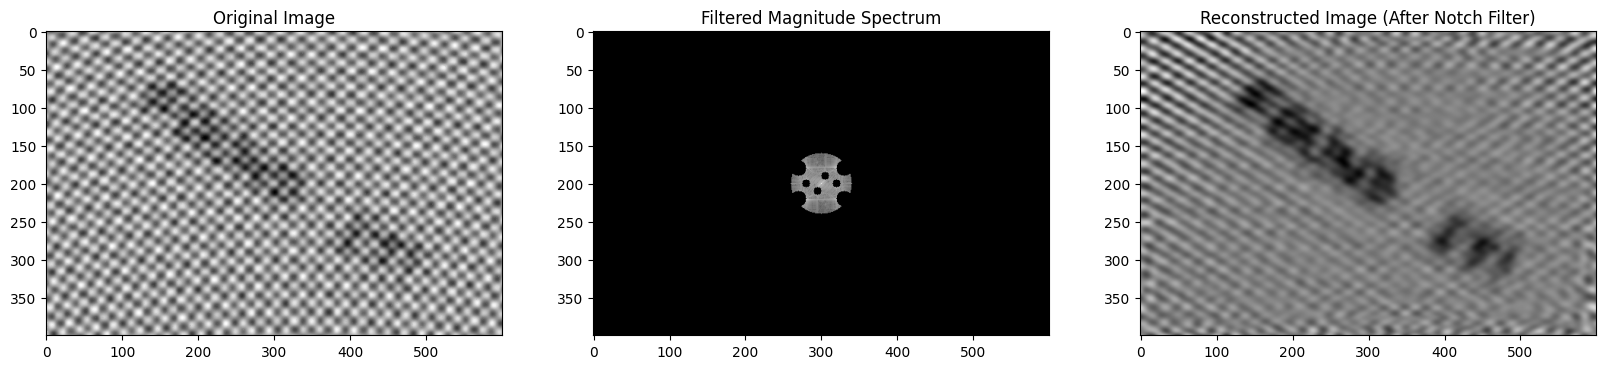

In [11]:
filtered_dft = dft_shift
filtered_dft *= inverted_notch_mask
# Use notch normal notch as well
filtered_dft *= notch_mask

magnitude_spectrum = cv2.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1])
magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)

# Inverse DFT
idft_shift = np.fft.ifftshift(filtered_dft)
reconstructed = cv2.idft(idft_shift)
reconstructed = cv2.magnitude(reconstructed[:, :, 0], reconstructed[:, :, 1])

# Normalize for display
reconstructed = cv2.normalize(reconstructed, None, 0, 255, cv2.NORM_MINMAX)
reconstructed = np.uint8(reconstructed)

# Display Results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(inpainted, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Filtered Magnitude Spectrum')

axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title('Reconstructed Image (After Notch Filter)')

plt.show()